# Mercury Challenge Time Series Baserate Models

This notebook explains the development of the Mercury Challenge Baserate models for the Case Count events.  We present the underlying time series data, and examine autocorrelation and partial autocorrelation functions.  Using the first 2/3 of the series history we fit a family of ARIMA(p,d,q) models and evaluate on the final 1/3 of the series history, using an error function derived from the Mercury Challenge Quality Score function.  $Error = mean(1 - QS)$.  Finally, we make predictions for the most recent history (3 months for monthly events, 1 month for weekly and daily events) by fitting a model of the optimal order to the series that precedes the final period and making predictions.

In [1]:
%matplotlib inline

In [51]:
import os
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.parser import parse
import sys
sys.path.append(("../.."))
from Baserate.main.timeseries import (
    evaluate_arima_model, 
    evaluate_models, 
    mean_qs_error, 
    TsDefaults,
    one_step_ahead_forecast,
    hist_avg_predict,
    future_dates
)
from ExpressScore.main.express_score import CaseCountScorer
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight");

In [3]:
MC_HOME = os.path.abspath("../../..")
DATA_PATH = os.path.join(MC_HOME, "data")
GSR_PATH = os.path.join(DATA_PATH, "gsr")
CU_COUNT_GSR_PATH = os.path.join(GSR_PATH, "cu_count_gsr")
DISEASE_GSR_PATH = os.path.join(GSR_PATH, "disease_gsr")
RESOURCE_PATH = os.path.join(MC_HOME, "src", "Baserate", "resources")

P_MAX = TsDefaults.P_MAX # Up to lag 4
D_MAX = TsDefaults.D_MAX # Up to the first difference
Q_MAX = TsDefaults.Q_MAX # Up to lag 4

model_eval_dict = dict()

## Egypt Daily CU

In [5]:
freq, place = ("Daily", "Egypt")

A plot of the case counts over time is shown below.

Data from 2015-05-01 00:00:00 to 2018-06-30 00:00:00


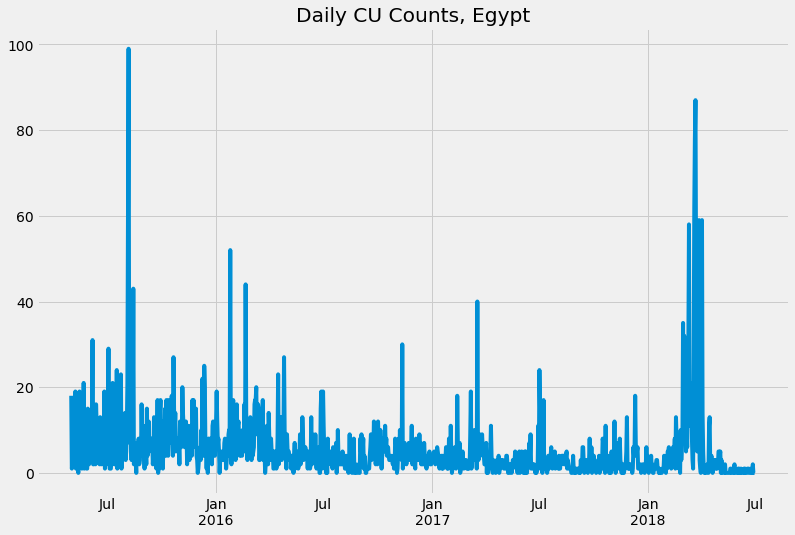

In [6]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

The Augmented Dickey-Fuller test checks for non-stationarity, which is rejected in this case (and all the following cases).  The plots below show the autocorrelation and partial autocorrelation functions for the history.  These give us insight into the appropriate order for the time series model.

Testing for Stationary Behavior
ADF Statistic: -5.289
p = 5.767795601388069e-06
Critical Values:
1%: -3.436
5%: -2.864
10%: -2.568
ADF Test rejects null hypothesis of non-stationarity


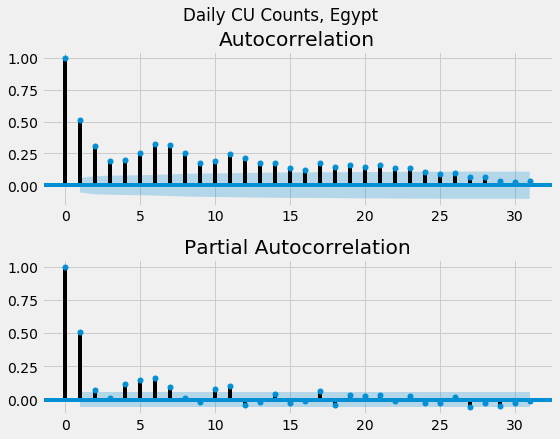

In [7]:
is_non_stationary = True
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
    is_non_stationary = False
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")
fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=31)
plot_pacf(count_ser, ax=axes[1], lags=31)
fig.suptitle("{0} CU Counts, {1}".format(freq, place), y=1.02)
fig.tight_layout()

Use a grid search to find ARIMA order, using the error function derived from the Quality Score metric.

In [8]:
if is_non_stationary:
    d_max = D_MAX 
else:
    d_max = 0
model_eval = evaluate_models(count_ser, range(P_MAX+1), range(d_max+1), range(Q_MAX+1), verbose=False)
print(model_eval)
model_eval_dict[place] = model_eval

{'Order': (2, 0, 1), 'Model_Params': array([ 5.34836857,  1.30436972, -0.32675549, -0.8888926 ]), 'Error': 0.4152948681735336}


Backtest using June 2018

Mean QS = 0.292
            Predicted  Actual  Quality_Score
2018-06-01        1.0     0.0           0.75
2018-06-02        2.0     1.0           0.75
2018-06-03        2.0     0.0           0.50
2018-06-04        2.0     1.0           0.75
2018-06-05        2.0     0.0           0.50
2018-06-06        3.0     0.0           0.25
2018-06-07        3.0     1.0           0.50
2018-06-08        3.0     0.0           0.25
2018-06-09        3.0     0.0           0.25
2018-06-10        3.0     0.0           0.25
2018-06-11        3.0     0.0           0.25
2018-06-12        3.0     1.0           0.50
2018-06-13        3.0     0.0           0.25
2018-06-14        3.0     1.0           0.50
2018-06-15        3.0     0.0           0.25
2018-06-16        3.0     0.0           0.25
2018-06-17        3.0     0.0           0.25
2018-06-18        4.0     1.0           0.25
2018-06-19        4.0     1.0           0.25
2018-06-20        4.0     1.0           0.25
2018-06-21        4.0     0.0          

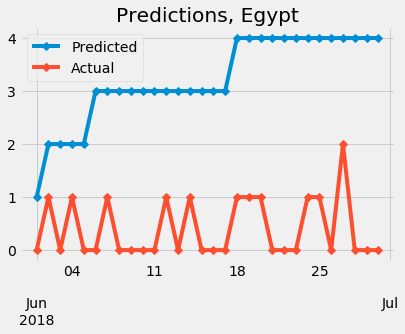

In [9]:
test_start_date = "2018-06-01"
train = count_ser[:test_start_date]
test = count_ser[test_start_date:]
order = model_eval_dict[place]["Order"]
model = sm.tsa.ARIMA(endog=train, order=order)
model_fit = model.fit(disp=0)
predict = model_fit.forecast(steps=len(test))[0]
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test.index)
predict_df = pd.DataFrame({"Predicted": predict_ser,
                           "Actual": test})
predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                       x.Actual),
                                               axis=1)
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))
print(predict_df)

predict_df[["Predicted", "Actual"]].plot(marker="D")
plt_title = "Predictions, {}".format(place)
plt.title(plt_title);

In [10]:
freq = "Weekly"

## Tahrir Weekly CU

In [11]:
place = "Tahrir"

Data from 2015-04-29 00:00:00 to 2018-06-27 00:00:00


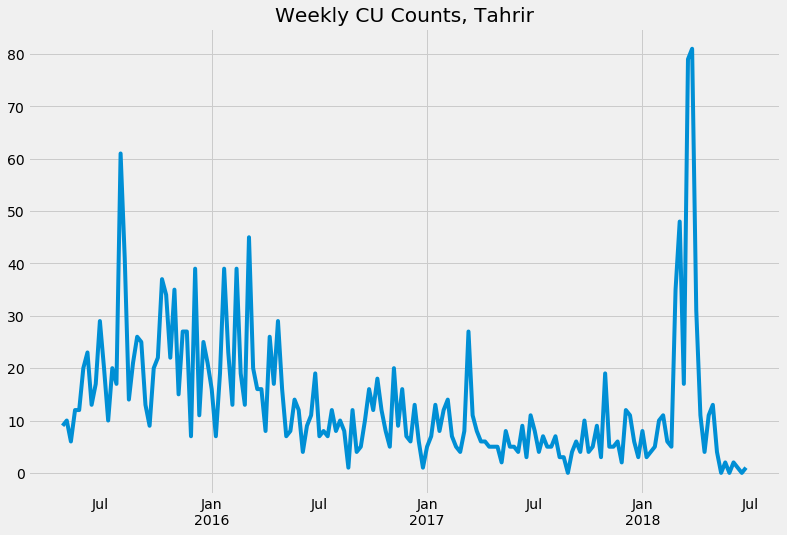

In [12]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Testing for Stationary Behavior
ADF Statistic: -3.923
p = 0.0018720299083905133
Critical Values:
1%: -3.471
5%: -2.879
10%: -2.576
ADF Test rejects null hypothesis of non-stationarity


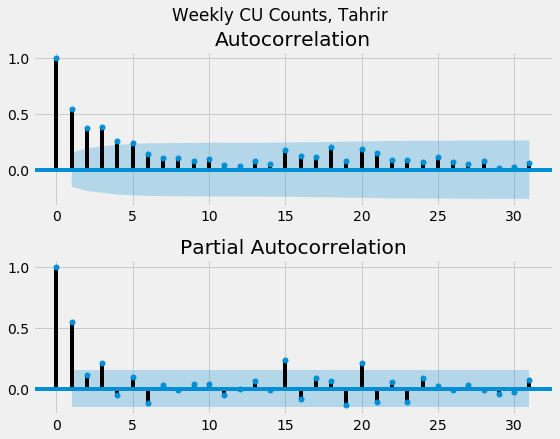

In [13]:
is_non_stationary = True
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
    is_non_stationary = False
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")
fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=31)
plot_pacf(count_ser, ax=axes[1], lags=31)
fig.suptitle("{0} CU Counts, {1}".format(freq, place), y=1.02)
fig.tight_layout()

Use a grid search to find ARIMA order

In [14]:
if is_non_stationary:
    d_max = D_MAX 
else:
    d_max = 0
model_eval = evaluate_models(count_ser, range(P_MAX+1), range(d_max+1), range(Q_MAX+1), verbose=False)
print(model_eval)
model_eval_dict[place] = model_eval

{'Order': (1, 0, 3), 'Model_Params': array([13.21940539,  0.69143151, -0.19989999, -0.15440225,  0.22803605]), 'Error': 0.45546648460232236}


Backtest using June 2018

Mean QS = 0.161
            Predicted  Actual  Quality_Score
2018-06-06        5.0     2.0       0.400000
2018-06-13        7.0     1.0       0.142857
2018-06-20        8.0     0.0       0.000000
2018-06-27       10.0     1.0       0.100000


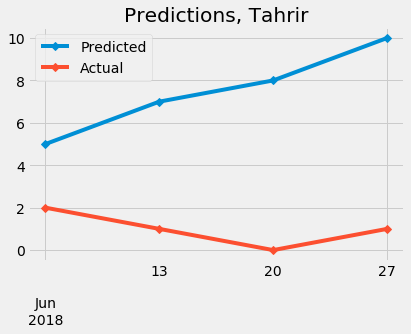

In [15]:
test_start_date = "2018-06-01"
train = count_ser[:test_start_date]
test = count_ser[test_start_date:]
order = model_eval_dict[place]["Order"]
model = sm.tsa.ARIMA(endog=train, order=order)
model_fit = model.fit(disp=0)
predict = model_fit.forecast(steps=len(test))[0]
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test.index)
predict_df = pd.DataFrame({"Predicted": predict_ser,
                           "Actual": test})
predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                       x.Actual),
                                               axis=1)
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))
print(predict_df)

predict_df[["Predicted", "Actual"]].plot(marker="D")
plt_title = "Predictions, {}".format(place)
plt.title(plt_title);

## Jordan Weekly CU

In [16]:
place = "Jordan"

Data from 2015-04-29 00:00:00 to 2018-06-27 00:00:00


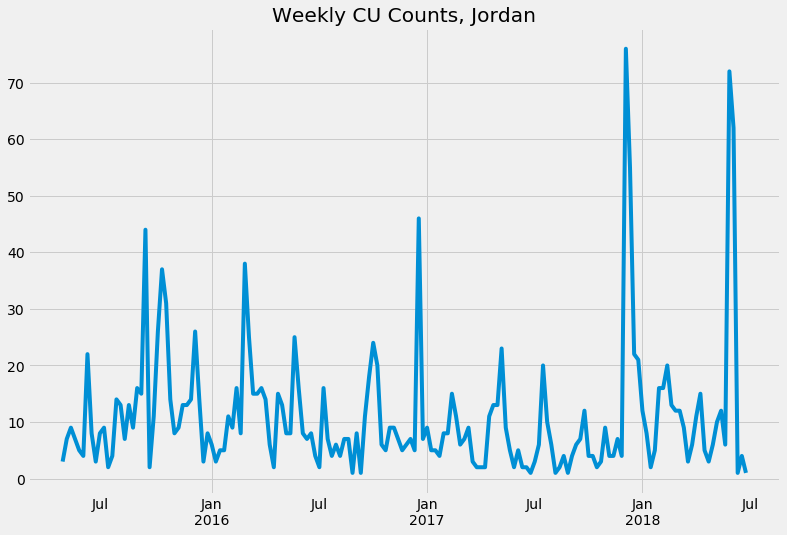

In [17]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Testing for Stationary Behavior
ADF Statistic: -7.884
p = 4.6191786254637625e-12
Critical Values:
1%: -3.471
5%: -2.879
10%: -2.576
ADF Test rejects null hypothesis of non-stationarity


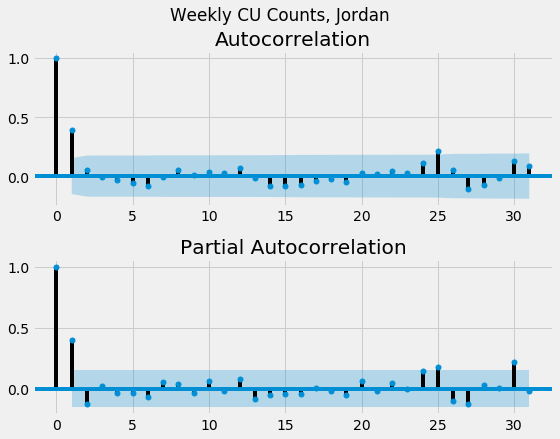

In [18]:
is_non_stationary = True
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
    is_non_stationary = False
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")
fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=31)
plot_pacf(count_ser, ax=axes[1], lags=31)
fig.suptitle("{0} CU Counts, {1}".format(freq, place), y=1.02)
fig.tight_layout()

Use a grid search to find ARIMA order

In [19]:
if is_non_stationary:
    d_max = D_MAX 
else:
    d_max = 0
model_eval = evaluate_models(count_ser, range(P_MAX+1), range(d_max+1), range(Q_MAX+1), verbose=False)
print(model_eval)
model_eval_dict[place] = model_eval

{'Order': (4, 0, 0), 'Model_Params': array([11.02792169,  0.45024845, -0.15446369,  0.06735045, -0.03486694]), 'Error': 0.44692563630220655}


Backtest using June 2018

Mean QS = 0.248
            Predicted  Actual  Quality_Score
2018-06-06       35.0      62       0.564516
2018-06-13       19.0       1       0.052632
2018-06-20       14.0       4       0.285714
2018-06-27       11.0       1       0.090909


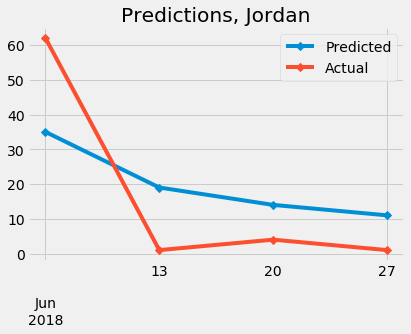

In [20]:
test_start_date = "2018-06-01"
train = count_ser[:test_start_date]
test = count_ser[test_start_date:]
order = model_eval_dict[place]["Order"]
model = sm.tsa.ARIMA(endog=train, order=order)
model_fit = model.fit(disp=0)
predict = model_fit.forecast(steps=len(test))[0]
predict = [round(p) for p in predict]
predict_ser = pd.Series(predict, index=test.index)
predict_df = pd.DataFrame({"Predicted": predict_ser,
                           "Actual": test})
predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                       x.Actual),
                                               axis=1)
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))
print(predict_df)

predict_df[["Predicted", "Actual"]].plot(marker="D")
plt_title = "Predictions, {}".format(place)
plt.title(plt_title);

In [21]:
freq = "Monthly"

## Amman Monthly CU

In [22]:
place="Amman"

Data from 2015-05-01 00:00:00 to 2018-06-01 00:00:00


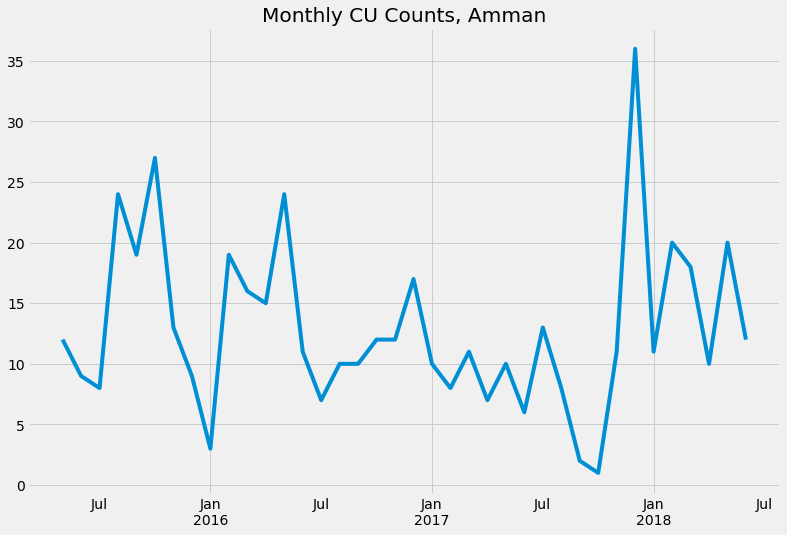

In [23]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Testing for Stationary Behavior
ADF Statistic: -4.959
p = 2.678191570148539e-05
Critical Values:
1%: -3.621
5%: -2.944
10%: -2.610
ADF Test rejects null hypothesis of non-stationarity


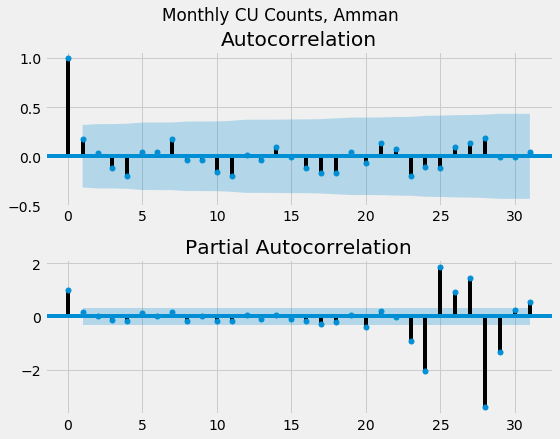

In [24]:
is_non_stationary = True
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
    is_non_stationary = False
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")
fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=31)
plot_pacf(count_ser, ax=axes[1], lags=31)
fig.suptitle("{0} CU Counts, {1}".format(freq, place), y=1.02)
fig.tight_layout()

Use a grid search to find ARIMA order

In [25]:
if is_non_stationary:
    d_max = D_MAX 
else:
    d_max = 0
model_eval = evaluate_models(count_ser, range(P_MAX+1), range(d_max+1), range(Q_MAX+1), verbose=False)
print(model_eval)
model_eval_dict[place] = model_eval

{'Order': (0, 0, 0), 'Model_Params': array([12.94594595]), 'Error': 0.3778763971071663}


Backtest using April - June 2018

Mean QS = 0.781
            Predicted  Actual  Quality_Score
2018-04-01         13      10       0.769231
2018-05-01         13      20       0.650000
2018-06-01         13      12       0.923077


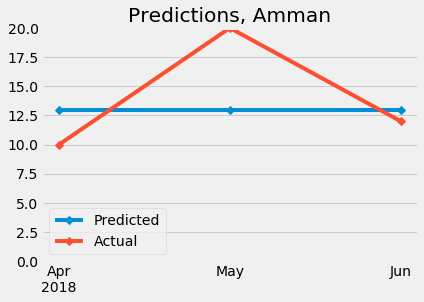

In [26]:
test_start_date = "2018-03-31"
train = count_ser[:test_start_date]
train = train.apply(lambda x: float(x))
test = count_ser[test_start_date:]
test = test.apply(lambda x: float(x))

order = model_eval["Order"]
predict_ser = one_step_ahead_forecast(train, test, order)
predict_df = pd.DataFrame({"Predicted": predict_ser.apply(lambda x: int(round(x))),
                           "Actual": test.apply(lambda x: int(round(x)))})

predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                       x.Actual),
                                               axis=1)
y_max = max(predict_df.Predicted.max(), predict_df.Actual.max())
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))
print(predict_df)

predict_df[["Predicted", "Actual"]].plot(marker="D")
plt_title = "Predictions, {}".format(place)
plt.ylim(0, y_max)
plt.title(plt_title);

## Irbid Monthly CU

In [27]:
place="Irbid"

Data from 2015-05-01 00:00:00 to 2018-06-01 00:00:00


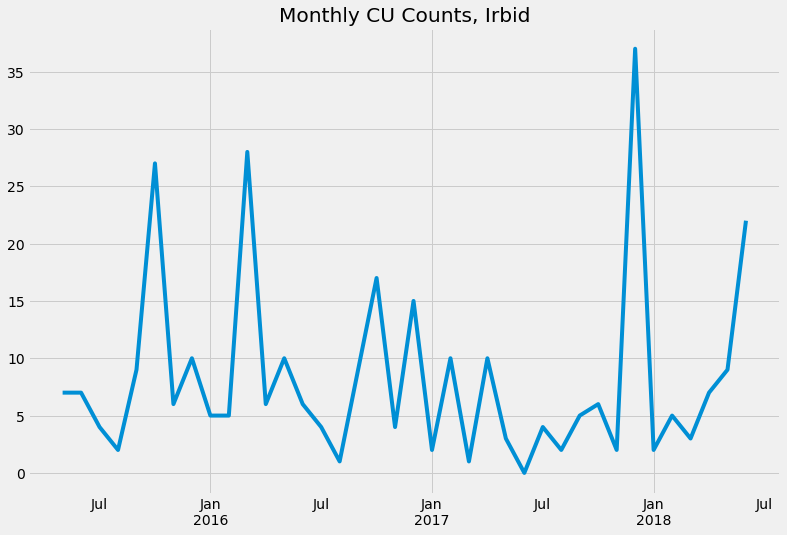

In [28]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)*1.0
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Testing for Stationary Behavior
ADF Statistic: -6.740
p = 3.1404363659014203e-09
Critical Values:
1%: -3.621
5%: -2.944
10%: -2.610
ADF Test rejects null hypothesis of non-stationarity


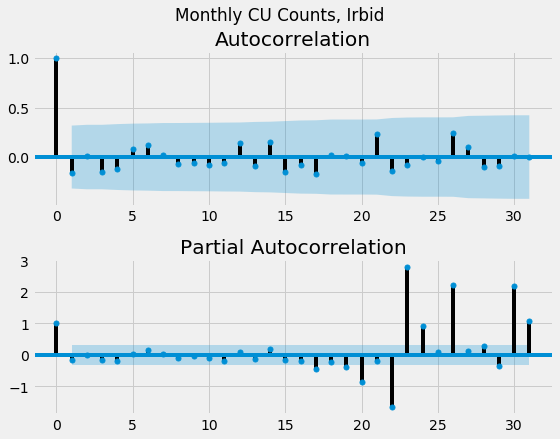

In [29]:
is_non_stationary = True
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
    is_non_stationary = False
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")
fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=31)
plot_pacf(count_ser, ax=axes[1], lags=31)
fig.suptitle("{0} CU Counts, {1}".format(freq, place), y=1.02)
fig.tight_layout()

Use a grid search to find ARIMA order

In [30]:
if is_non_stationary:
    d_max = D_MAX 
else:
    d_max = 0
model_eval = evaluate_models(count_ser, range(P_MAX+1), range(d_max+1), range(Q_MAX+1), verbose=False)
print(model_eval)
model_eval_dict[place] = model_eval

{'Order': (0, 0, 3), 'Model_Params': array([ 7.87525206, -0.21195896,  0.02901362, -0.18861988]), 'Error': 0.5001650751650752}


Mean QS = 0.746
            Predicted  Actual  Quality_Score
2018-04-01          8       7       0.875000
2018-05-01          9       9       1.000000
2018-06-01          8      22       0.363636


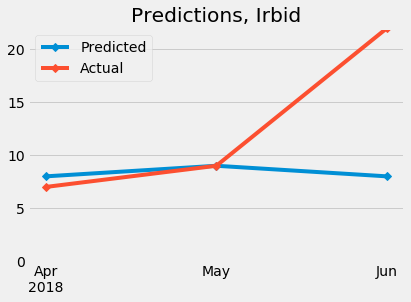

In [31]:
test_start_date = "2018-03-31"
train = count_ser[:test_start_date]
train = train.apply(lambda x: float(x))
test = count_ser[test_start_date:]
test = test.apply(lambda x: float(x))

order = model_eval["Order"]
predict_ser = one_step_ahead_forecast(train, test, order)
predict_df = pd.DataFrame({"Predicted": predict_ser.apply(lambda x: int(round(x))),
                           "Actual": test.apply(lambda x: int(round(x)))})
predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                       x.Actual),
                                               axis=1)
y_max = max(predict_df.Predicted.max(), predict_df.Actual.max())
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))
print(predict_df)

predict_df[["Predicted", "Actual"]].plot(marker="D")
plt_title = "Predictions, {}".format(place)
plt.ylim(0, y_max)
plt.title(plt_title);

## Madaba Monthly CU

In [32]:
place = "Madaba"

Data from 2015-05-01 00:00:00 to 2018-06-01 00:00:00


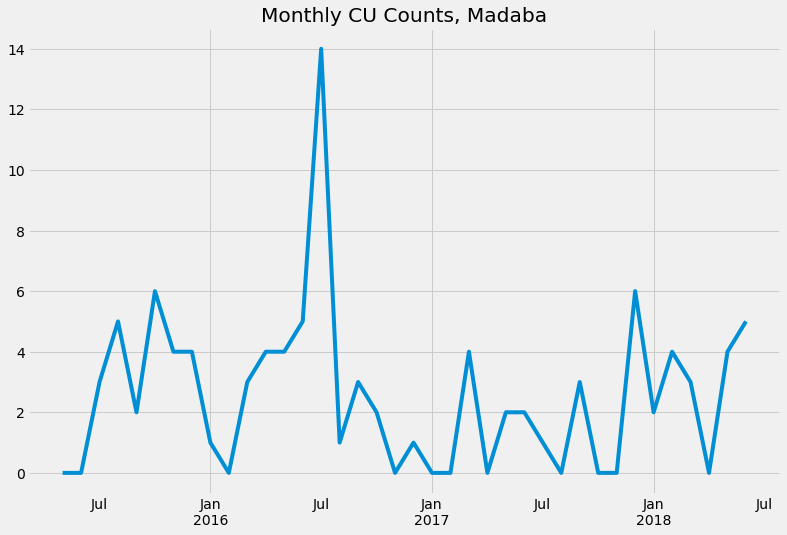

In [33]:
filename_ = "{0}_{1}_Counts.json".format(place, freq)
filepath_ = os.path.join(CU_COUNT_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
count_dict = {parse(e["Event_Date"]): e["Case_Count"] for e in gsr_}
count_ser = pd.Series(count_dict)*1.0
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("{0} CU Counts, {1}".format(freq, place));

Testing for Stationary Behavior
ADF Statistic: -5.215
p = 8.184690041025979e-06
Critical Values:
1%: -3.621
5%: -2.944
10%: -2.610
ADF Test rejects null hypothesis of non-stationarity


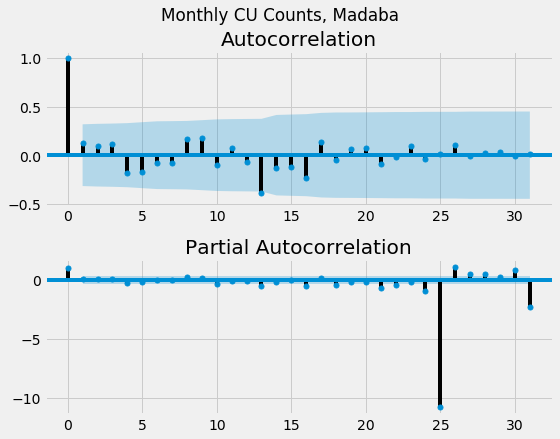

In [34]:
is_non_stationary = True
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
    is_non_stationary = False
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")
fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=31)
plot_pacf(count_ser, ax=axes[1], lags=31)
fig.suptitle("{0} CU Counts, {1}".format(freq, place), y=1.02)
fig.tight_layout()

Use a grid search to find ARIMA order

In [35]:
if is_non_stationary:
    d_max = D_MAX 
else:
    d_max = 0
model_eval = evaluate_models(count_ser, range(P_MAX+1), range(d_max+1), range(Q_MAX+1), verbose=False)
print(model_eval)
model_eval_dict[place] = model_eval

{'Order': (3, 0, 0), 'Model_Params': array([2.46929093, 0.08918833, 0.10550317, 0.09514781]), 'Error': 0.3666666666666666}


Mean QS = 0.383
            Predicted  Actual  Quality_Score
2018-04-01          3       0           0.25
2018-05-01          2       4           0.50
2018-06-01          2       5           0.40


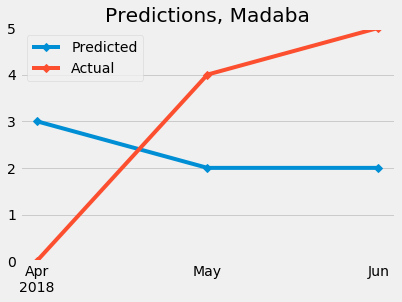

In [36]:
test_start_date = "2018-03-31"
train = count_ser[:test_start_date]
train = train.apply(lambda x: float(x))
test = count_ser[test_start_date:]
test = test.apply(lambda x: float(x))

order = model_eval["Order"]
predict_ser = one_step_ahead_forecast(train, test, order)
predict_df = pd.DataFrame({"Predicted": predict_ser.apply(lambda x: int(round(x))),
                           "Actual": test.apply(lambda x: int(round(x)))})
predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                       x.Actual),
                                               axis=1)
y_max = max(predict_df.Predicted.max(), predict_df.Actual.max())
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))
print(predict_df)

predict_df[["Predicted", "Actual"]].plot(marker="D")
plt_title = "Predictions, {}".format(place)
plt.ylim(0, y_max)
plt.title(plt_title);

Exporting model parameters to JSON

In [82]:
for k in model_eval_dict:
    model_eval_dict[k]["Model_Params"] = [x for x in model_eval_dict[k]["Model_Params"]]
out_path = os.path.join(RESOURCE_PATH, "CU TS Model Parameters.json")
with open(out_path, "w") as f:
    json.dump(model_eval_dict, f, indent=2)